## Results

In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import time
import copy
import os
import gc
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import initializers
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from scipy import interpolate
from sklearn.preprocessing import StandardScaler

In [3]:
def category_preds(predictions, raw_predictions):
    final_preds = []
    preds = predictions + 1
    for idx in range(len(predictions)):
        side = int(preds[idx])
        if side == 0:
            prob_value = - (raw_predictions[idx, side] - (1/3))
        elif side == 1:
            prob_value = 0
        elif side == 2:
            prob_value = (raw_predictions[idx, side] - (1/3))
        else:
            raise Exception('this shouldnt happen!')
        final_preds.append(prob_value)
    return np.array(final_preds)

def increase_wave_len(full_wave, wave_len_increase):
    full_wave[-2] = full_wave[0] # match the start and end
    x = np.arange(len(full_wave))
    f = interpolate.interp1d(x, full_wave)
    x_new = np.arange(0,len(full_wave)-1, 1/wave_len_increase)
    y_new = f(x_new)
    return y_new
# new_wave = increase_wave_len(full_wave, wave_len_increase=1)
# plt.plot(new_wave)

def create_waves(starting_price=100, overall_wave_len=0.1, overall_wave_amp=1, 
                     secondary_wave_amp=0.5, noise_amp=0, trend=0):
    data = []
    slow_cosine_wave = np.cos(np.arange(0, 12.7, 0.1))
    fast_cosine_wave = np.cos(np.arange(0, 12.7 * 6, 0.1 * 6)) * secondary_wave_amp
    full_wave = slow_cosine_wave + fast_cosine_wave
    full_wave = increase_wave_len(full_wave, overall_wave_len)
    noise = np.random.randn(len(full_wave)) * noise_amp
    full_wave = (full_wave  + noise) * overall_wave_amp
    calc_start_diff = starting_price - full_wave[0] 
    full_wave += calc_start_diff
    full_wave += ((np.array(range(len(full_wave)+1))**trend) - 1)[1:]  # [1:] stops **trend giving neg values
    return full_wave

def wave_data(wave_cycles=100, starting_price=100):
    data = np.array([])
    for w in range(wave_cycles):
        full_wave = create_waves(starting_price=starting_price, overall_wave_len=1, overall_wave_amp=1, 
                                     secondary_wave_amp=0.5, noise_amp=0, trend=0)
        starting_price = full_wave[-1]
        data = np.concatenate([data, full_wave])
    return data

def sliding_window(data, window = 4, step = 2):
    shape = (data.size - window + 1, window)
    strides = data.strides * 2
    window_data = np.lib.stride_tricks.as_strided(data, strides=strides, shape=shape)[0::step]
    return window_data

## Raw values with regression

In [4]:
window = 10
raw_data = wave_data(wave_cycles=100, starting_price=100)
raw_data = np.expand_dims(raw_data, axis=1)
window_data = sliding_window(raw_data.flatten(), window=window, step=1)

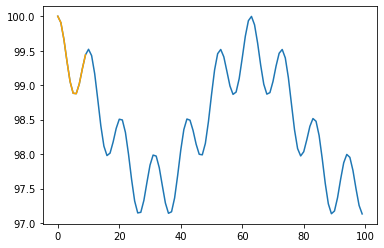

In [5]:
plt.plot(raw_data.flatten()[0:100])
plt.plot(window_data[0].flatten(), c='orange')
x = window_data[:,:-1]
y = window_data[:,-1]

In [6]:
model = tf.keras.Sequential([
    layers.Dense(units=10, activation='relu', input_shape=[window-1,]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation=None),
])

In [12]:
## Learning Schedule = 1e-2, 1e-2, 1e-3 for each run ##
opt = tf.keras.optimizers.Adam(lr=1e-3)
#opt = tf.keras.optimizers.RMSprop(lr=1e-5)
#opt = tf.keras.optimizers.SGD(lr=1e-5)
model.compile(optimizer=opt, loss='mse')
now = time.time()
model.fit(x, y, epochs=2500, batch_size=5000)
time.time() - now

Train on 12591 samples
Epoch 1/2500
12591/12591 [==============================] - 0s 19us/sample - loss: 1.1752
Epoch 2/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 1.1426
Epoch 3/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.2680
Epoch 4/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.7167
Epoch 5/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1485
Epoch 6/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.4060
Epoch 7/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1140
Epoch 8/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.2461
Epoch 9/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0969
Epoch 10/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1609
Epoch 11/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 92/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 93/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 94/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 95/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 96/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 97/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 98/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 99/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 100/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 101/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 102/2500
12591/1

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 182/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 183/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 184/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 185/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 186/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0670
Epoch 187/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0670
Epoch 188/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0671
Epoch 189/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0672
Epoch 190/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0672
Epoch 191/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0673
Epoch 192/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 272/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 273/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 274/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 275/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 276/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 277/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0666
Epoch 278/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 279/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 280/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 281/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 282/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 361/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoch 362/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0664
Epoch 363/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0664
Epoch 364/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoch 365/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0664
Epoch 366/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 367/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 368/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 369/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 370/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 371/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0673
Epoch 451/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0671
Epoch 452/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 453/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 454/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoch 455/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 456/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 457/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoch 458/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoch 459/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0660
Epoch 460/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 461/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 540/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoch 541/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0659
Epoch 542/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0658
Epoch 543/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 544/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0675
Epoch 545/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0677
Epoch 546/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0671
Epoch 547/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0661
Epoch 548/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0687
Epoch 549/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0670
Epoch 550/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0734
Epoch 630/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0691
Epoch 631/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0740
Epoch 632/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0694
Epoch 633/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoch 634/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0671
Epoch 635/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0664
Epoch 636/2500
12591/12591 [==============================] - ETA: 0s - loss: 0.064 - 0s 1us/sample - loss: 0.0657
Epoch 637/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0684
Epoch 638/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0671
Epoch 639/2500
12591/12591 [==============================] - 0s 1us/sample - los

Epoch 719/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0658
Epoch 720/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 721/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0661
Epoch 722/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0653
Epoch 723/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0664
Epoch 724/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoch 725/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0658
Epoch 726/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0652
Epoch 727/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0653
Epoch 728/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0677
Epoch 729/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0652

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0658
Epoch 809/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0651
Epoch 810/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0649
Epoch 811/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0649
Epoch 812/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 813/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0674
Epoch 814/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0650
Epoch 815/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0677
Epoch 816/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0700
Epoch 817/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0650
Epoch 818/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0655
Epoch 819/2500

Epoch 898/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0660
Epoch 899/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 900/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0765
Epoch 901/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0727
Epoch 902/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0710
Epoch 903/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0757
Epoch 904/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0666
Epoch 905/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0681
Epoch 906/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0709
Epoch 907/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0657
Epoch 908/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0701

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0651
Epoch 989/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0658
Epoch 990/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0697
Epoch 991/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0665
Epoch 992/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0680
Epoch 993/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 994/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0650
Epoch 995/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0691
Epoch 996/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0652
Epoch 997/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0647
Epoch 998/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0650
Epoch 999/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0689
Epoch 1078/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0673
Epoch 1079/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0679
Epoch 1080/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0718
Epoch 1081/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0704
Epoch 1082/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 1083/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0659
Epoch 1084/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoch 1085/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0694
Epoch 1086/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 1087/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0654
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0689
Epoch 1166/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0659
Epoch 1167/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0661
Epoch 1168/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0690
Epoch 1169/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0645
Epoch 1170/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoch 1171/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0706
Epoch 1172/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0695
Epoch 1173/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0804
Epoch 1174/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0714
Epoch 1175/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0680
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0636
Epoch 1254/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0644
Epoch 1255/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0641
Epoch 1256/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0640
Epoch 1257/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0683
Epoch 1258/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0651
Epoch 1259/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0639
Epoch 1260/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0646
Epoch 1261/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0639
Epoch 1262/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0657
Epoch 1263/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0641
Epoch 1343/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0650
Epoch 1344/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0678
Epoch 1345/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0657
Epoch 1346/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0661
Epoch 1347/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0645
Epoch 1348/2500
12591/12591 [==============================] - ETA: 0s - loss: 0.062 - 0s 1us/sample - loss: 0.0641
Epoch 1349/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0682
Epoch 1350/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0637
Epoch 1351/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0656
Epoch 1352/2500
12591/12591 [==============================] - 0s 1us/sa

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0689
Epoch 1431/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0644
Epoch 1432/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0688
Epoch 1433/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0646
Epoch 1434/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0688
Epoch 1435/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0633
Epoch 1436/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0664
Epoch 1437/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0659
Epoch 1438/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0630
Epoch 1439/2500
12591/12591 [==============================] - ETA: 0s - loss: 0.063 - 0s 1us/sample - loss: 0.0639
Epoch 1440/2500
12591/12591 [==============================] - 0s 1us/sa

Epoch 1519/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0634
Epoch 1520/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0628
Epoch 1521/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0630
Epoch 1522/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0633
Epoch 1523/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0631
Epoch 1524/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0647
Epoch 1525/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0651
Epoch 1526/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0633
Epoch 1527/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0639
Epoch 1528/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0643
Epoch 1529/2500
12591/12591 [==============================] - 0s 1us/sample - l

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0667
Epoch 1609/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0644
Epoch 1610/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0709
Epoch 1611/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0652
Epoch 1612/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0645
Epoch 1613/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0706
Epoch 1614/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0745
Epoch 1615/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0656
Epoch 1616/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoch 1617/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0643
Epoch 1618/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0637
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0639
Epoch 1698/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0671
Epoch 1699/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0657
Epoch 1700/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0637
Epoch 1701/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0681
Epoch 1702/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0642
Epoch 1703/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0636
Epoch 1704/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0669
Epoch 1705/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0678
Epoch 1706/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0636
Epoch 1707/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0636
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0624
Epoch 1787/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0621
Epoch 1788/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0630
Epoch 1789/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoch 1790/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0717
Epoch 1791/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0650
Epoch 1792/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0627
Epoch 1793/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoch 1794/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0625
Epoch 1795/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0645
Epoch 1796/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0663
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0679
Epoch 1876/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0628
Epoch 1877/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0620
Epoch 1878/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0616
Epoch 1879/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0620
Epoch 1880/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoch 1881/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0704
Epoch 1882/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0640
Epoch 1883/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0698
Epoch 1884/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0676
Epoch 1885/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0644
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0638
Epoch 1965/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0631
Epoch 1966/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0615
Epoch 1967/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0616
Epoch 1968/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0634
Epoch 1969/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0620
Epoch 1970/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0631
Epoch 1971/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0624
Epoch 1972/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0627
Epoch 1973/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0626
Epoch 1974/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0620
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0642
Epoch 2054/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0642
Epoch 2055/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0689
Epoch 2056/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0648
Epoch 2057/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0668
Epoch 2058/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0635
Epoch 2059/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0662
Epoch 2060/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoch 2061/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0633
Epoch 2062/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0611
Epoch 2063/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0610
Epoch 2142/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0612
Epoch 2143/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0609
Epoch 2144/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0610
Epoch 2145/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0610
Epoch 2146/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0614
Epoch 2147/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0620
Epoch 2148/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0619
Epoch 2149/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoch 2150/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0643
Epoch 2151/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0609
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0633
Epoch 2231/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0613
Epoch 2232/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0638
Epoch 2233/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0611
Epoch 2234/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0647
Epoch 2235/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0616
Epoch 2236/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0660
Epoch 2237/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0619
Epoch 2238/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0678
Epoch 2239/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0610
Epoch 2240/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0613
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0625
Epoch 2320/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0605
Epoch 2321/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0607
Epoch 2322/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0607
Epoch 2323/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0630
Epoch 2324/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0637
Epoch 2325/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0616
Epoch 2326/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0615
Epoch 2327/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0625
Epoch 2328/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0673
Epoch 2329/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0633
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0619
Epoch 2409/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0631
Epoch 2410/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0616
Epoch 2411/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0626
Epoch 2412/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0607
Epoch 2413/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0604
Epoch 2414/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0603
Epoch 2415/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0601
Epoch 2416/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0601
Epoch 2417/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0600
Epoch 2418/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0625
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0615
Epoch 2497/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0634
Epoch 2498/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0641
Epoch 2499/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0622
Epoch 2500/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0611


25.571933031082153

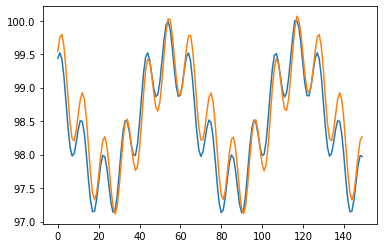

In [13]:
preds = model.predict(x)
plt.plot(raw_data.flatten()[0+window-1:150+window-1])
#plt.plot(x[0])
plt.plot(preds[0:150])

## Standardized raw values with regression

In [39]:
window = 10
raw_data = wave_data(wave_cycles=100, starting_price=100)
raw_data = np.expand_dims(raw_data, axis=1)
window_data = sliding_window(raw_data.flatten(), window=window, step=1)

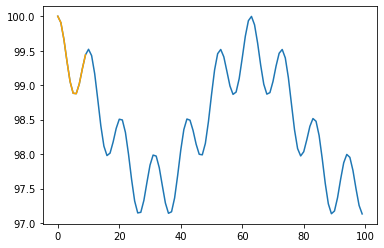

In [40]:
plt.plot(raw_data.flatten()[0:100])
plt.plot(window_data[0].flatten(), c='orange')
x_raw = window_data[:,:-1]
scaler = StandardScaler()
x = scaler.fit_transform(x_raw)
y = window_data[:,-1]

In [41]:
model = tf.keras.Sequential([
    layers.Dense(units=10, activation='relu', input_shape=[window-1,]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation=None),
])

In [43]:
## Learning Schedule = 1e-2, 1e-2, 1e-3 for each run ##
opt = tf.keras.optimizers.Adam(lr=1e-3)
#opt = tf.keras.optimizers.RMSprop(lr=1e-5)
#opt = tf.keras.optimizers.SGD(lr=1e-5)
model.compile(optimizer=opt, loss='mse')
now = time.time()
model.fit(x, y, epochs=2500, batch_size=5000)
time.time() - now

Train on 12591 samples
Epoch 1/2500
12591/12591 [==============================] - 0s 16us/sample - loss: 0.1826
Epoch 2/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1833
Epoch 3/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0392
Epoch 4/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1007
Epoch 5/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0194
Epoch 6/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0546
Epoch 7/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0096
Epoch 8/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0313
Epoch 9/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0060
Epoch 10/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0170
Epoch 11/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 92/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 93/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 94/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 95/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 96/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 97/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 98/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 99/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 100/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 101/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 102/2500
12591/1

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 182/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 183/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 184/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 185/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 186/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 187/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 188/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 189/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 190/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 191/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 192/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 272/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 273/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 274/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 275/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 276/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 277/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 278/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 279/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 280/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 281/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 282/2500

Epoch 361/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 362/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 363/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 364/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 365/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 366/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 367/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 368/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 369/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 370/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 371/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0024
Epoch 452/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0019
Epoch 453/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0015
Epoch 454/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0026
Epoch 455/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 456/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0017
Epoch 457/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 458/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0018
Epoch 459/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 460/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0014
Epoch 461/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 462/2500

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 541/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 542/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 543/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.8397e-04
Epoch 544/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 545/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 546/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.7963e-04
Epoch 547/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0015
Epoch 548/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0017
Epoch 549/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 550/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 

12591/12591 [==============================] - 0s 1us/sample - loss: 9.1287e-04
Epoch 630/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.1758e-04
Epoch 631/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.9102e-04
Epoch 632/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.0322e-04
Epoch 633/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.3562e-04
Epoch 634/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.6795e-04
Epoch 635/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 636/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 637/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 638/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0017
Epoch 639/2500
12591/12591 [==============================] - 0s 1us/sample - los

12591/12591 [==============================] - 0s 1us/sample - loss: 9.6416e-04
Epoch 718/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0018
Epoch 719/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 720/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 721/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0014
Epoch 722/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.1598e-04
Epoch 723/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.3160e-04
Epoch 724/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.6850e-04
Epoch 725/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 726/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0020
Epoch 727/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.690

12591/12591 [==============================] - 0s 1us/sample - loss: 7.8895e-04
Epoch 806/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.0467e-04
Epoch 807/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.8303e-04
Epoch 808/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.5704e-04
Epoch 809/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.8054e-04
Epoch 810/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.9361e-04
Epoch 811/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.2723e-04
Epoch 812/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 813/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.5758e-04
Epoch 814/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 815/2500
12591/12591 [==============================] - 0s 1us/samp

12591/12591 [==============================] - 0s 1us/sample - loss: 7.3034e-04
Epoch 894/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.1286e-04
Epoch 895/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.2250e-04
Epoch 896/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.2005e-04
Epoch 897/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.2719e-04
Epoch 898/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.1024e-04
Epoch 899/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.4462e-04
Epoch 900/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0017
Epoch 901/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.1832e-04
Epoch 902/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 903/2500
12591/12591 [==============================] - 0s 1us/samp

Epoch 980/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8247e-04
Epoch 981/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.1484e-04
Epoch 982/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9307e-04
Epoch 983/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8686e-04
Epoch 984/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.2879e-04
Epoch 985/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9933e-04
Epoch 986/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8448e-04
Epoch 987/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.4974e-04
Epoch 988/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.7837e-04
Epoch 989/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 990/2500
12591/12591 [==========================

12591/12591 [==============================] - 0s 1us/sample - loss: 8.5279e-04
Epoch 1067/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.4209e-04
Epoch 1068/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.3677e-04
Epoch 1069/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.3781e-04
Epoch 1070/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9327e-04
Epoch 1071/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.1430e-04
Epoch 1072/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.1192e-04
Epoch 1073/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.4823e-04
Epoch 1074/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.1051e-04
Epoch 1075/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.4668e-04
Epoch 1076/2500
12591/12591 [===========================

12591/12591 [==============================] - 0s 1us/sample - loss: 6.2953e-04
Epoch 1153/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.0080e-04
Epoch 1154/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8052e-04
Epoch 1155/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 1156/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.6456e-04
Epoch 1157/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 1158/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0018
Epoch 1159/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0024
Epoch 1160/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0021
Epoch 1161/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.2993e-04
Epoch 1162/2500
12591/12591 [==============================] - 0s 1us/sample

12591/12591 [==============================] - 0s 1us/sample - loss: 6.2147e-04
Epoch 1239/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.8621e-04
Epoch 1240/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.1038e-04
Epoch 1241/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 1242/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 1243/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.3965e-04
Epoch 1244/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.7902e-04
Epoch 1245/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 1246/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0012
Epoch 1247/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0013
Epoch 1248/2500
12591/12591 [==============================] - 0s 1us/sample

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0015
Epoch 1325/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.0295e-04
Epoch 1326/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.5062e-04
Epoch 1327/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.4546e-04
Epoch 1328/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9425e-04
Epoch 1329/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.5113e-04
Epoch 1330/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.7572e-04
Epoch 1331/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.6553e-04
Epoch 1332/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.0700e-04
Epoch 1333/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.9864e-04
Epoch 1334/2500
12591/12591 [==============================]

12591/12591 [==============================] - 0s 1us/sample - loss: 4.7885e-04
Epoch 1411/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.0139e-04
Epoch 1412/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.1023e-04
Epoch 1413/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.7619e-04
Epoch 1414/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.4198e-04
Epoch 1415/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.2806e-04
Epoch 1416/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.4977e-04
Epoch 1417/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.0275e-04
Epoch 1418/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.6274e-04
Epoch 1419/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.2634e-04
Epoch 1420/2500
12591/12591 [===========================

Epoch 1496/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.4662e-04
Epoch 1497/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.7627e-04
Epoch 1498/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.3319e-04
Epoch 1499/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.5723e-04
Epoch 1500/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 1501/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.3969e-04
Epoch 1502/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 1503/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.6486e-04
Epoch 1504/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9727e-04
Epoch 1505/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.2551e-04
Epoch 1506/2500
12591/12591 [===================

12591/12591 [==============================] - 0s 1us/sample - loss: 6.2277e-04
Epoch 1583/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.2678e-04
Epoch 1584/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8176e-04
Epoch 1585/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.2149e-04
Epoch 1586/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.6405e-04
Epoch 1587/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.0988e-04
Epoch 1588/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.6115e-04
Epoch 1589/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.6497e-04
Epoch 1590/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.7488e-04
Epoch 1591/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.8063e-04
Epoch 1592/2500
12591/12591 [===========================

12591/12591 [==============================] - 0s 1us/sample - loss: 7.5940e-04
Epoch 1668/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.2332e-04
Epoch 1669/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.8828e-04
Epoch 1670/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.7920e-04
Epoch 1671/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8166e-04
Epoch 1672/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.6542e-04
Epoch 1673/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.5533e-04
Epoch 1674/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.0675e-04
Epoch 1675/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7810e-04
Epoch 1676/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.4335e-04
Epoch 1677/2500
12591/12591 [===========================

12591/12591 [==============================] - 0s 1us/sample - loss: 4.1874e-04
Epoch 1753/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.1144e-04
Epoch 1754/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.4833e-04
Epoch 1755/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.8734e-04
Epoch 1756/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.0473e-04
Epoch 1757/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.7420e-04
Epoch 1758/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7471e-04
Epoch 1759/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7484e-04
Epoch 1760/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7043e-04
Epoch 1761/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.4064e-04
Epoch 1762/2500
12591/12591 [===========================

12591/12591 [==============================] - 0s 1us/sample - loss: 5.3827e-04
Epoch 1839/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.0047e-04
Epoch 1840/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.5397e-04
Epoch 1841/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.0926e-04
Epoch 1842/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.4249e-04
Epoch 1843/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.8756e-04
Epoch 1844/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.4681e-04
Epoch 1845/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0011
Epoch 1846/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0014
Epoch 1847/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.7558e-04
Epoch 1848/2500
12591/12591 [==============================] - 0

12591/12591 [==============================] - 0s 1us/sample - loss: 3.9954e-04
Epoch 1924/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.6563e-04
Epoch 1925/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9381e-04
Epoch 1926/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.5097e-04
Epoch 1927/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.0649e-04
Epoch 1928/2500
12591/12591 [==============================] - ETA: 0s - loss: 6.2321e-0 - 0s 1us/sample - loss: 5.4796e-04
Epoch 1929/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.2821e-04
Epoch 1930/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.8229e-04
Epoch 1931/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.8137e-04
Epoch 1932/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.0706e-04
Epoch 1933/2500
12591/12591 

12591/12591 [==============================] - 0s 1us/sample - loss: 3.3526e-04
Epoch 2009/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7073e-04
Epoch 2010/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.5979e-04
Epoch 2011/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.9437e-04
Epoch 2012/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0010
Epoch 2013/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0014
Epoch 2014/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.4533e-04
Epoch 2015/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7640e-04
Epoch 2016/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.3445e-04
Epoch 2017/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.7202e-04
Epoch 2018/2500
12591/12591 [==============================] - 0

12591/12591 [==============================] - 0s 1us/sample - loss: 2.5191e-04
Epoch 2095/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.5140e-04
Epoch 2096/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.5510e-04
Epoch 2097/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.6409e-04
Epoch 2098/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.7761e-04
Epoch 2099/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.0157e-04
Epoch 2100/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.8339e-04
Epoch 2101/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 8.0999e-04
Epoch 2102/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0016
Epoch 2103/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0020
Epoch 2104/2500
12591/12591 [==============================] - 0

Epoch 2180/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.4644e-04
Epoch 2181/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.9041e-04
Epoch 2182/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.3195e-04
Epoch 2183/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.6222e-04
Epoch 2184/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.1607e-04
Epoch 2185/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 9.9808e-04
Epoch 2186/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.8625e-04
Epoch 2187/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.0716e-04
Epoch 2188/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.2466e-04
Epoch 2189/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.8872e-04
Epoch 2190/2500
12591/12591 [===========

12591/12591 [==============================] - 0s 1us/sample - loss: 3.1660e-04
Epoch 2266/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.0560e-04
Epoch 2267/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.0367e-04
Epoch 2268/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.2397e-04
Epoch 2269/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.0240e-04
Epoch 2270/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.0885e-04
Epoch 2271/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.4951e-04
Epoch 2272/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 6.0670e-04
Epoch 2273/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.2272e-04
Epoch 2274/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.4879e-04
Epoch 2275/2500
12591/12591 [===========================

12591/12591 [==============================] - 0s 1us/sample - loss: 2.6158e-04
Epoch 2351/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.3647e-04
Epoch 2352/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.3780e-04
Epoch 2353/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.1511e-04
Epoch 2354/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.8773e-04
Epoch 2355/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 5.3303e-04
Epoch 2356/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 7.6843e-04
Epoch 2357/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.8349e-04
Epoch 2358/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.8580e-04
Epoch 2359/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.7590e-04
Epoch 2360/2500
12591/12591 [===========================

12591/12591 [==============================] - 0s 1us/sample - loss: 2.4078e-04
Epoch 2437/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.9339e-04
Epoch 2438/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.7652e-04
Epoch 2439/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.9923e-04
Epoch 2440/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 4.4353e-04
Epoch 2441/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.5445e-04
Epoch 2442/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.5192e-04
Epoch 2443/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 3.4020e-04
Epoch 2444/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.5755e-04
Epoch 2445/2500
12591/12591 [==============================] - 0s 1us/sample - loss: 2.2810e-04
Epoch 2446/2500
12591/12591 [===========================

26.052955627441406

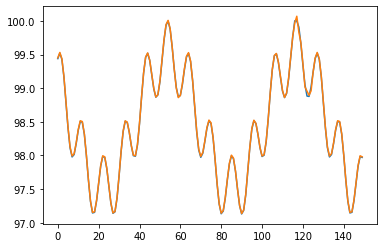

In [44]:
preds = model.predict(x)
plt.plot(raw_data.flatten()[0+window-1:150+window-1])
#plt.plot(x[0])
plt.plot(preds[0:150])

## Raw values and classification

In [30]:
window = 10
raw_data = wave_data(wave_cycles=100, starting_price=100)
raw_data = np.expand_dims(raw_data, axis=1)
window_data = sliding_window(raw_data.flatten(), window=window, step=1)

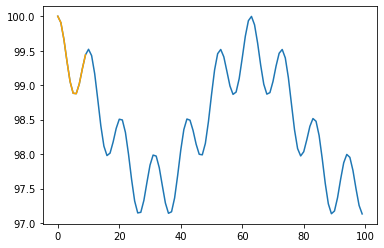

In [31]:
plt.plot(raw_data.flatten()[0:100])
plt.plot(window_data[0].flatten(), c='orange')
x = window_data[:,:-1]
#y = window_data[:,-1]
y_diff = np.diff(window_data[:,-2:])
y = np.where(y_diff < 0, 0, 1) # classification task

In [32]:
model = tf.keras.Sequential([
    layers.Dense(units=10, activation='relu', input_shape=[window-1,]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid'),
])

In [35]:
## Learning Schedule = 1e-2, 1e-2, 1e-3 for each run ##
opt = tf.keras.optimizers.Adam(lr=1e-4)
#opt = tf.keras.optimizers.RMSprop(lr=1e-5)
#opt = tf.keras.optimizers.SGD(lr=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
now = time.time()
model.fit(x, y, epochs=1000, batch_size=5000)
time.time() - now

Train on 12591 samples
Epoch 1/1000
12591/12591 [==============================] - 0s 30us/sample - loss: 0.3172 - accuracy: 0.8494
Epoch 2/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3163 - accuracy: 0.8291
Epoch 3/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3113 - accuracy: 0.8418
Epoch 4/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3144 - accuracy: 0.8492
Epoch 5/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3112 - accuracy: 0.8416
Epoch 6/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3126 - accuracy: 0.8298
Epoch 7/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3110 - accuracy: 0.8456
Epoch 8/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3113 - accuracy: 0.8492
Epoch 9/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3111 - accuracy: 0.8352
Epoc

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3102 - accuracy: 0.8474
Epoch 76/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3105 - accuracy: 0.8364
Epoch 77/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3106 - accuracy: 0.8459
Epoch 78/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3106 - accuracy: 0.8418
Epoch 79/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3102 - accuracy: 0.8400
Epoch 80/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3103 - accuracy: 0.8474
Epoch 81/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3105 - accuracy: 0.8389
Epoch 82/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3112 - accuracy: 0.8453
Epoch 83/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3114 - accuracy: 0.8420
Epoch 84/1000
12591/12591 [======

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3097 - accuracy: 0.8413
Epoch 150/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3098 - accuracy: 0.8334
Epoch 151/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3106 - accuracy: 0.8492
Epoch 152/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3101 - accuracy: 0.8405
Epoch 153/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3101 - accuracy: 0.8421
Epoch 154/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3096 - accuracy: 0.8436
Epoch 155/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3101 - accuracy: 0.8360
Epoch 156/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3096 - accuracy: 0.8413
Epoch 157/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3097 - accuracy: 0.8457
Epoch 158/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3094 - accuracy: 0.8424
Epoch 224/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3096 - accuracy: 0.8458
Epoch 225/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3094 - accuracy: 0.8398
Epoch 226/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3093 - accuracy: 0.8462
Epoch 227/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3090 - accuracy: 0.8431
Epoch 228/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3096 - accuracy: 0.8395
Epoch 229/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3093 - accuracy: 0.8430
Epoch 230/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3091 - accuracy: 0.8397
Epoch 231/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3093 - accuracy: 0.8352
Epoch 232/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3087 - accuracy: 0.8476
Epoch 298/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3087 - accuracy: 0.8334
Epoch 299/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3088 - accuracy: 0.8492
Epoch 300/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3085 - accuracy: 0.8439
Epoch 301/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3090 - accuracy: 0.8414
Epoch 302/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3089 - accuracy: 0.8492
Epoch 303/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3085 - accuracy: 0.8362
Epoch 304/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3086 - accuracy: 0.8381
Epoch 305/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3085 - accuracy: 0.8413
Epoch 306/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3086 - accuracy: 0.8423
Epoch 372/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3084 - accuracy: 0.8459
Epoch 373/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3082 - accuracy: 0.8408
Epoch 374/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3082 - accuracy: 0.8387
Epoch 375/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3091 - accuracy: 0.8492
Epoch 376/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3089 - accuracy: 0.8369
Epoch 377/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3082 - accuracy: 0.8464
Epoch 378/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3085 - accuracy: 0.8425
Epoch 379/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3086 - accuracy: 0.8376
Epoch 380/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3076 - accuracy: 0.8462
Epoch 446/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3079 - accuracy: 0.8447
Epoch 447/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3078 - accuracy: 0.8431
Epoch 448/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3075 - accuracy: 0.8432
Epoch 449/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3076 - accuracy: 0.8383
Epoch 450/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3078 - accuracy: 0.8492
Epoch 451/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3080 - accuracy: 0.8408
Epoch 452/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3085 - accuracy: 0.8460
Epoch 453/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3078 - accuracy: 0.8436
Epoch 454/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3073 - accuracy: 0.8412
Epoch 520/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3069 - accuracy: 0.8492
Epoch 521/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3069 - accuracy: 0.8368
Epoch 522/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3070 - accuracy: 0.8466
Epoch 523/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3069 - accuracy: 0.8427
Epoch 524/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3071 - accuracy: 0.8393
Epoch 525/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3070 - accuracy: 0.8366
Epoch 526/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3070 - accuracy: 0.8457
Epoch 527/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3070 - accuracy: 0.8396
Epoch 528/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3067 - accuracy: 0.8412
Epoch 594/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3065 - accuracy: 0.8492
Epoch 595/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3065 - accuracy: 0.8374
Epoch 596/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3062 - accuracy: 0.8429
Epoch 597/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3065 - accuracy: 0.8492
Epoch 598/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3068 - accuracy: 0.8346
Epoch 599/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3072 - accuracy: 0.8461
Epoch 600/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3070 - accuracy: 0.8408
Epoch 601/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3064 - accuracy: 0.8424
Epoch 602/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3063 - accuracy: 0.8449
Epoch 668/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3058 - accuracy: 0.8465
Epoch 669/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3060 - accuracy: 0.8472
Epoch 670/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3058 - accuracy: 0.8384
Epoch 671/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3060 - accuracy: 0.8492
Epoch 672/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3060 - accuracy: 0.8403
Epoch 673/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3060 - accuracy: 0.8433
Epoch 674/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3057 - accuracy: 0.8427
Epoch 675/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3062 - accuracy: 0.8369
Epoch 676/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3052 - accuracy: 0.8413
Epoch 742/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3053 - accuracy: 0.8452
Epoch 743/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3052 - accuracy: 0.8381
Epoch 744/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3053 - accuracy: 0.8400
Epoch 745/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3052 - accuracy: 0.8443
Epoch 746/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3052 - accuracy: 0.8428
Epoch 747/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3051 - accuracy: 0.8474
Epoch 748/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3053 - accuracy: 0.8395
Epoch 749/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3059 - accuracy: 0.8492
Epoch 750/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3046 - accuracy: 0.8413
Epoch 816/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3046 - accuracy: 0.8466
Epoch 817/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3046 - accuracy: 0.8437
Epoch 818/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3047 - accuracy: 0.8434
Epoch 819/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3045 - accuracy: 0.8474
Epoch 820/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3046 - accuracy: 0.8424
Epoch 821/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3046 - accuracy: 0.8471
Epoch 822/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3045 - accuracy: 0.8430
Epoch 823/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3046 - accuracy: 0.8492
Epoch 824/1000
12591/1259

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3042 - accuracy: 0.8447
Epoch 890/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3042 - accuracy: 0.8435
Epoch 891/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3042 - accuracy: 0.8492
Epoch 892/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3043 - accuracy: 0.8492
Epoch 893/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3041 - accuracy: 0.8377
Epoch 894/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3041 - accuracy: 0.8463
Epoch 895/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3041 - accuracy: 0.8474
Epoch 896/1000
12591/12591 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.84 - 0s 1us/sample - loss: 0.3042 - accuracy: 0.8402
Epoch 897/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3040 - 

12591/12591 [==============================] - 0s 1us/sample - loss: 0.3035 - accuracy: 0.8453
Epoch 963/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3038 - accuracy: 0.8481
Epoch 964/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3042 - accuracy: 0.8426
Epoch 965/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3041 - accuracy: 0.8492
Epoch 966/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3036 - accuracy: 0.8416
Epoch 967/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3038 - accuracy: 0.8454
Epoch 968/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3039 - accuracy: 0.8443
Epoch 969/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3039 - accuracy: 0.8459
Epoch 970/1000
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3035 - accuracy: 0.8477
Epoch 971/1000
12591/1259

12.278975009918213

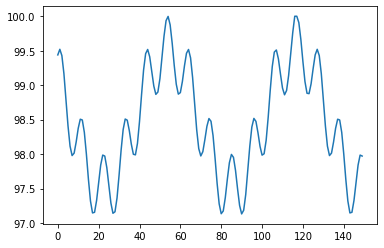

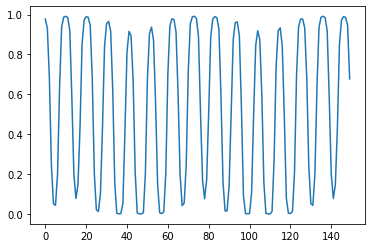

In [36]:
preds = model.predict(x)
plt.plot(raw_data.flatten()[0+window-1:150+window-1])
#plt.plot(x[0])
plt.show()
plt.plot(preds[0:150])

## Standardized raw values with classification

In [37]:
window = 10
raw_data = wave_data(wave_cycles=100, starting_price=100)
raw_data = np.expand_dims(raw_data, axis=1)
window_data = sliding_window(raw_data.flatten(), window=window, step=1)

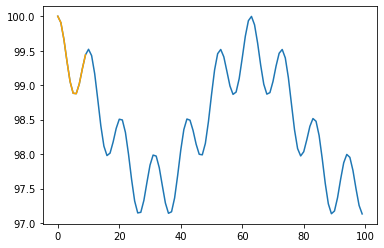

In [45]:
plt.plot(raw_data.flatten()[0:100])
plt.plot(window_data[0].flatten(), c='orange')
x_raw = window_data[:,:-1]
scaler = StandardScaler()
x = scaler.fit_transform(x_raw)
#y = window_data[:,-1]
y_diff = np.diff(window_data[:,-2:])
y = np.where(y_diff < 0, 0, 1) # classification task

In [46]:
model = tf.keras.Sequential([
    layers.Dense(units=10, activation='relu', input_shape=[window-1,]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid'),
])

In [47]:
opt = tf.keras.optimizers.Adam(lr=7e-4)
#opt = tf.keras.optimizers.RMSprop(lr=1e-5)
#opt = tf.keras.optimizers.SGD(lr=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
now = time.time()
model.fit(x, y, epochs=300, batch_size=5000)
time.time() - now

Train on 12591 samples
Epoch 1/300
12591/12591 [==============================] - 0s 21us/sample - loss: 0.6765 - accuracy: 0.5798
Epoch 2/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6706 - accuracy: 0.6179
Epoch 3/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6649 - accuracy: 0.6536
Epoch 4/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6594 - accuracy: 0.6506
Epoch 5/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6542 - accuracy: 0.6621
Epoch 6/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6492 - accuracy: 0.6619
Epoch 7/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6445 - accuracy: 0.6775
Epoch 8/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6398 - accuracy: 0.7097
Epoch 9/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.6348 - accuracy: 0.7111
Epoch 10/300


Epoch 76/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3228 - accuracy: 0.8492
Epoch 77/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3199 - accuracy: 0.8511
Epoch 78/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3169 - accuracy: 0.8571
Epoch 79/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3137 - accuracy: 0.8571
Epoch 80/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3106 - accuracy: 0.8571
Epoch 81/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3074 - accuracy: 0.8571
Epoch 82/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3042 - accuracy: 0.8571
Epoch 83/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.3011 - accuracy: 0.8571
Epoch 84/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.2981 - accuracy: 0.8589
Epoch 85/300
12591/12591 [==

12591/12591 [==============================] - 0s 1us/sample - loss: 0.1065 - accuracy: 0.9842
Epoch 152/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1041 - accuracy: 0.9861
Epoch 153/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.1019 - accuracy: 0.9921
Epoch 154/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0997 - accuracy: 0.9921
Epoch 155/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0976 - accuracy: 0.9921
Epoch 156/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0956 - accuracy: 0.9921
Epoch 157/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0935 - accuracy: 0.9935
Epoch 158/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0916 - accuracy: 1.0000
Epoch 159/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0897 - accuracy: 1.0000
Epoch 160/300
12591/12591 [======

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0342 - accuracy: 1.0000
Epoch 227/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0339 - accuracy: 1.0000
Epoch 228/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0335 - accuracy: 1.0000
Epoch 229/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0332 - accuracy: 1.0000
Epoch 230/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0329 - accuracy: 1.0000
Epoch 231/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0326 - accuracy: 1.0000
Epoch 232/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0323 - accuracy: 1.0000
Epoch 233/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0319 - accuracy: 1.0000
Epoch 234/300
12591/12591 [==============================] - 0s 1us/sample - loss: 0.0316 - accuracy: 1.0000
Epoch 235/300
12591/12591 [======

12591/12591 [==============================] - 0s 1us/sample - loss: 0.0161 - accuracy: 1.0000


3.868993043899536

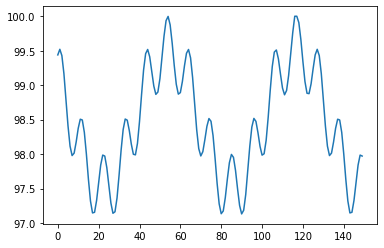

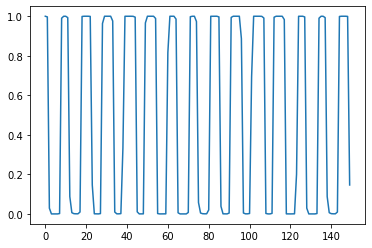

In [48]:
preds = model.predict(x)
plt.plot(raw_data.flatten()[0+window-1:150+window-1])
#plt.plot(x[0])
plt.show()
plt.plot(preds[0:150])

## Pct values with classification

In [49]:
window = 10
raw_data = wave_data(wave_cycles=100, starting_price=100)
raw_data = np.expand_dims(raw_data, axis=1)
raw_diff = np.diff(raw_data.flatten()) / raw_data.flatten()[:-1]

window_data = sliding_window(raw_diff, window=window, step=1)

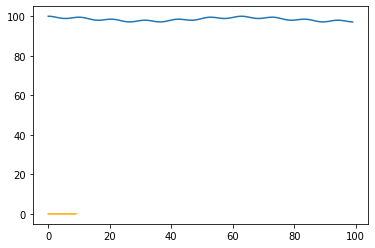

In [50]:
plt.plot(raw_data.flatten()[0:100])
plt.plot(window_data[0].flatten(), c='orange')
x = window_data[:,:-1]
#y = window_data[:,-1]
y_diff = np.diff(window_data[:,-2:])
y = np.where(y_diff < 0, 0, 1) # classification task

In [51]:
model = tf.keras.Sequential([
    layers.Dense(units=10, activation='relu', input_shape=[window-1,]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid'),
])

In [52]:
opt = tf.keras.optimizers.Adam(lr=1e-2)
#opt = tf.keras.optimizers.RMSprop(lr=1e-5)
#opt = tf.keras.optimizers.SGD(lr=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
now = time.time()
model.fit(x, y, epochs=1000, batch_size=5000)
time.time() - now

Train on 12590 samples
Epoch 1/1000
12590/12590 [==============================] - 0s 21us/sample - loss: 0.6932 - accuracy: 0.5141
Epoch 2/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6930 - accuracy: 0.6166
Epoch 3/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6929 - accuracy: 0.5986
Epoch 4/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6926 - accuracy: 0.5000
Epoch 5/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6923 - accuracy: 0.5000
Epoch 6/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6918 - accuracy: 0.7454
Epoch 7/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6911 - accuracy: 0.5000
Epoch 8/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6896 - accuracy: 0.5000
Epoch 9/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.6879 - accuracy: 0.6535
Epoc

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0696 - accuracy: 0.9603
Epoch 76/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0693 - accuracy: 0.9601
Epoch 77/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0689 - accuracy: 0.9593
Epoch 78/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0693 - accuracy: 0.9600
Epoch 79/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0685 - accuracy: 0.9603
Epoch 80/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0688 - accuracy: 0.9600
Epoch 81/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0699 - accuracy: 0.9604
Epoch 82/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0692 - accuracy: 0.9562
Epoch 83/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0679 - accuracy: 0.9608
Epoch 84/1000
12590/12590 [======

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0670 - accuracy: 0.9624
Epoch 150/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0684 - accuracy: 0.9658
Epoch 151/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0637 - accuracy: 0.9635
Epoch 152/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0627 - accuracy: 0.9631
Epoch 153/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0622 - accuracy: 0.9634
Epoch 154/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0619 - accuracy: 0.9603
Epoch 155/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0619 - accuracy: 0.9603
Epoch 156/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0648 - accuracy: 0.9620
Epoch 157/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0647 - accuracy: 0.9652
Epoch 158/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0597 - accuracy: 0.9722
Epoch 224/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0578 - accuracy: 0.9667
Epoch 225/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0572 - accuracy: 0.9617
Epoch 226/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0564 - accuracy: 0.9624
Epoch 227/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0561 - accuracy: 0.9622
Epoch 228/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0563 - accuracy: 0.9631
Epoch 229/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0563 - accuracy: 0.9666
Epoch 230/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0559 - accuracy: 0.9618
Epoch 231/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0562 - accuracy: 0.9637
Epoch 232/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0522 - accuracy: 0.9671
Epoch 298/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0553 - accuracy: 0.9692
Epoch 299/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0515 - accuracy: 0.9720
Epoch 300/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0495 - accuracy: 0.9732
Epoch 301/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0488 - accuracy: 0.9683
Epoch 302/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0485 - accuracy: 0.9663
Epoch 303/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0493 - accuracy: 0.9727
Epoch 304/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0497 - accuracy: 0.9716
Epoch 305/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0507 - accuracy: 0.9687
Epoch 306/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0402 - accuracy: 0.9815
Epoch 372/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0403 - accuracy: 0.9828
Epoch 373/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0433 - accuracy: 0.9763
Epoch 374/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0513 - accuracy: 0.9777
Epoch 375/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0457 - accuracy: 0.9719
Epoch 376/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0507 - accuracy: 0.9726
Epoch 377/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0479 - accuracy: 0.9809
Epoch 378/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0421 - accuracy: 0.9837
Epoch 379/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0421 - accuracy: 0.9774
Epoch 380/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0339 - accuracy: 0.9836
Epoch 446/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0325 - accuracy: 0.9863
Epoch 447/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0333 - accuracy: 0.9867
Epoch 448/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0338 - accuracy: 0.9797
Epoch 449/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0330 - accuracy: 0.9804
Epoch 450/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0338 - accuracy: 0.9797
Epoch 451/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0340 - accuracy: 0.9801
Epoch 452/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0330 - accuracy: 0.9851
Epoch 453/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0292 - accuracy: 0.9986
Epoch 454/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0214 - accuracy: 0.9967
Epoch 519/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0213 - accuracy: 0.9971
Epoch 520/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0217 - accuracy: 0.9970
Epoch 521/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0208 - accuracy: 1.0000
Epoch 522/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0278 - accuracy: 0.9840
Epoch 523/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0253 - accuracy: 0.9920
Epoch 524/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0217 - accuracy: 0.9966
Epoch 525/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0209 - accuracy: 0.9965
Epoch 526/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0205 - accuracy: 1.0000
Epoch 527/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0221 - accuracy: 0.9890
Epoch 593/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0224 - accuracy: 0.9935
Epoch 594/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0179 - accuracy: 0.9971
Epoch 595/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0162 - accuracy: 1.0000
Epoch 596/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0152 - accuracy: 1.0000
Epoch 597/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0152 - accuracy: 1.0000
Epoch 598/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0154 - accuracy: 1.0000
Epoch 599/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0155 - accuracy: 1.0000
Epoch 600/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0148 - accuracy: 1.0000
Epoch 601/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0112 - accuracy: 1.0000
Epoch 667/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0151 - accuracy: 0.9970
Epoch 668/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0135 - accuracy: 1.0000
Epoch 669/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0123 - accuracy: 1.0000
Epoch 670/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0127 - accuracy: 1.0000
Epoch 671/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0138 - accuracy: 0.9969
Epoch 672/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0171 - accuracy: 0.9939
Epoch 673/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0197 - accuracy: 0.9906
Epoch 674/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0198 - accuracy: 0.9904
Epoch 675/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0074 - accuracy: 1.0000
Epoch 741/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0076 - accuracy: 1.0000
Epoch 742/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0076 - accuracy: 1.0000
Epoch 743/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0073 - accuracy: 1.0000
Epoch 744/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0071 - accuracy: 1.0000
Epoch 745/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0070 - accuracy: 1.0000
Epoch 746/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0070 - accuracy: 1.0000
Epoch 747/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0074 - accuracy: 1.0000
Epoch 748/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0082 - accuracy: 1.0000
Epoch 749/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0051 - accuracy: 1.0000
Epoch 815/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0056 - accuracy: 1.0000
Epoch 816/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0055 - accuracy: 1.0000
Epoch 817/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0051 - accuracy: 1.0000
Epoch 818/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0052 - accuracy: 1.0000
Epoch 819/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0054 - accuracy: 1.0000
Epoch 820/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0059 - accuracy: 1.0000
Epoch 821/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0052 - accuracy: 1.0000
Epoch 822/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0048 - accuracy: 1.0000
Epoch 823/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0043 - accuracy: 1.0000
Epoch 889/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0043 - accuracy: 1.0000
Epoch 890/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0046 - accuracy: 1.0000
Epoch 891/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 892/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0036 - accuracy: 1.0000
Epoch 893/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0038 - accuracy: 1.0000
Epoch 894/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0043 - accuracy: 1.0000
Epoch 895/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0042 - accuracy: 1.0000
Epoch 896/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0034 - accuracy: 1.0000
Epoch 897/1000
12590/1259

12590/12590 [==============================] - 0s 1us/sample - loss: 0.0027 - accuracy: 1.0000
Epoch 963/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 964/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0025 - accuracy: 1.0000
Epoch 965/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 966/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0025 - accuracy: 1.0000
Epoch 967/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 968/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 969/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 970/1000
12590/12590 [==============================] - 0s 1us/sample - loss: 0.0026 - accuracy: 1.0000
Epoch 971/1000
12590/1259

12.257978439331055

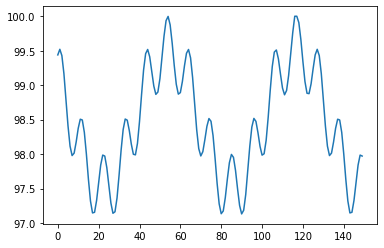

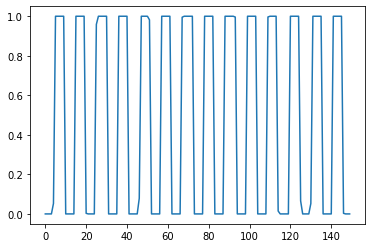

In [53]:
preds = model.predict(x)
plt.plot(raw_data.flatten()[0+window-1:150+window-1])
#plt.plot(x[0])
plt.show()
plt.plot(preds[0:150])